# IBM Data Science Capstone

## Introduction
The different neighborhoods of a city can have a distinctly different feel. I will be examining the neighborhoods of Seattle, and clustering them into groups of similar neighborhoods based on number and types of venues they contain. This analysis could be valuable to several groups of people. For example, business owners with a successful business in one neighborhood may be interested in similar areas where they could expand. Or perhaps residents planning to move between neighborhoods might want to know what neighborhoods are similar (or dissimilar) to where they currently live. 

In [20]:
# Imports, needed for code throughout the analysis
import pandas as pd
import numpy as np
import os
import requests
import folium
import geopy.distance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from math import cos, radians
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Data

The data used in this analysis comes from 2 sources. 

First, we need geographic data for Seattle's neighborhoods. This is downloaded from an open data set (found [here](https://gis-kingcounty.opendata.arcgis.com/datasets/neighborhood-centers-in-king-county-neighborhood-centers-point), under the "Download" menu). This data defines 46 different neighborhoods of Seattle and provides latitude and longitude coordinates for each. These coordinates will be needed to get the next data.

I decided to drop neighborhoods that were far from the city center, and arbitrarily decided that 13km was the cutoff. Calculating distances in terms of latitude and longitude coordinates is actually quite complicated (fun fact: the curvature of the Earth must be accounted for!), but fortunately the `geopy` library does the hard work for you. 33 neighborhoods remained within the cutoff distance.

In [2]:
df = pd.read_csv("Neighborhood_Centers_in_King_County___neighborhood_centers_point.csv")
df = df[['NAME', 'LATITUDE', 'LONGITUDE' ]]

seattle_coordinates = (47.6062, -122.3321)

distances = []
for idx, neighborhood in df.iterrows():
    neighborhood_coordinates = (neighborhood.LATITUDE, neighborhood.LONGITUDE)
    km_to_city_center = geopy.distance.distance(seattle_coordinates, neighborhood_coordinates).km
    distances.append(km_to_city_center)
df['KM_TO_CITY_CENTER'] = distances
drop_cities_farther_than = 13
df = df[df['KM_TO_CITY_CENTER'] <= drop_cities_farther_than]
df.head()

,NAME,LATITUDE,LONGITUDE,KM_TO_CITY_CENTER
1,Northgate Neighborhood,47.708593,-122.323276,11.403751
2,Lake City Neighborhood,47.719278,-122.295228,12.873825
4,Wedgewood Neighborhood,47.675783,-122.290273,8.350559
5,University District,47.661268,-122.313133,6.286332
6,Green Lake Neighborhood,47.679490,-122.325846,8.162216


Let's see those neighborhoods on a map:

In [16]:
seattle_map = folium.Map(location=seattle_coordinates, zoom_start=11)

for lat, lng, name in zip(df['LATITUDE'], df['LONGITUDE'], df['NAME']):
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        color='blue',
        fill=True,
        fill_opacity=1.0,
        popup=label
    ).add_to(seattle_map)
# Uncomment to show map
# seattle_map

#### *Screenshot of map, in case Notebook is untrusted:*

![image](seattle_map.png)

Next, we need to get venue data for each neighborhood. We will fetch this from the Foursquare API. This data contains numerous details for each venue, but we are mainly concerned with the `category`. There are hundreds of categories for venues, but they all converge into 10 top level categories, and we will be using these top level categories for this analysis. The top level categories are:
- Arts & Entertainment
- College & University
- Event
- Food
- Nightlife Spot
- Outdoors & Recreation
- Professional & Other Places
- Residence
- Shop & Service
- Travel & Transport

To get the venue data, we need to iterate through every category for every neighborhood and make a request to the Foursquare API for each. The design of the API creates a limitation, as it is only capable of returning venues within a certain radius from a point on the map. Unfortunately, the neighborhoods of Seattle are not shaped like perfect circles, so we will not get all the venues in a neighborhood, but it will have to do. I arbitrarily chose a radius of 250 meters.

Fetching this data requires doing `10 categories * 33 neighborhoods = 330 requests` to the API. Fortunately this is within the usage limits of the free tier. 

While testing these results, I noticed that many of the requests returned the API limit of 50 venues (for example, Fremont, Capitol Hill, and the International District all had at least 50 `Food` venues). This was a problem because if a neighborhood had more than 50 venues of a certain category, some of them would be left out and this would represent that neighborhood inaccurately. 

To get around this, if a request returned 50 venues, I would then perform a subsearch of that same area. I submitted 4 new requests to the API, each one searching a radius of 125 meters (half the original 250 meters) and centered 125 meters North, South, East, and West of the original search. These 4 subsearches are all contained within the original search, but do not cover all of it so it is possible that some venues were missed. These subsearches also overlap, so duplicate venues needed to be removed.

The code to do this was fairly verbose, so we will skip the details. The results were saved to a CSV file. 

In [213]:
vdf = pd.read_csv('seattle_venues.csv')
print('{} venues found!'.format(vdf.shape[0]))
vdf.head()

4598 venues found!


,VENUE,CATEGORY,TOP_LEVEL_CATEGORY,NEIGHBORHOOD,NEIGHBORHOOD_LAT,NEIGHBORHOOD_LNG
0,Westlake Dance Center,Dance Studio,Arts & Entertainment,Northgate Neighborhood,47.708593,-122.323276
1,Kidgits,General Entertainment,Arts & Entertainment,Northgate Neighborhood,47.708593,-122.323276
2,Hot Blonde Bum @ 5th And Northgate,Outdoor Sculpture,Arts & Entertainment,Northgate Neighborhood,47.708593,-122.323276
3,The Wolfe Den,Theme Park Ride / Attraction,Arts & Entertainment,Northgate Neighborhood,47.708593,-122.323276
4,Circulation,Art Gallery,Arts & Entertainment,Northgate Neighborhood,47.708593,-122.323276


## Methodology

In order to compare different neighborhoods using their respective venues, we must make some decisions about how we are going to interpret their venue data. 

First we must decide whether to use `CATEGORY` or `TOP_LEVEL_CATEGORY` to distinguish venue types. We can see how many unique values there are in each column, as well as get an idea how often they occur.

In [5]:
print('Unique CATEGORY values:', len(vdf.CATEGORY.unique()))
print('Unique TOP_LEVEL_CATEGORY values:', len(vdf.TOP_LEVEL_CATEGORY.unique()))
print('Mean frequency for CATEGORY values:', vdf.groupby('CATEGORY').count()['VENUE'].mean())
print('Mean frequency for TOP_LEVEL_CATEGORY values:', vdf.groupby('TOP_LEVEL_CATEGORY').count()['VENUE'].mean())

Unique CATEGORY values: 439
Unique TOP_LEVEL_CATEGORY values: 9
Mean frequency for CATEGORY values: 10.47380410022779
Mean frequency for TOP_LEVEL_CATEGORY values: 510.8888888888889


We can see that there are `439` different values in `CATEGORY` but only `10` different values in `TOP_LEVEL_CATEGORY`. Every unique value in these columns is considered to be fully unique (for example a `"Pizza Shop"` and `"Pizza Parlor"` would have no association, yet in reality they are similar) which would make it difficult to find similarities between our neighborhoods with the 439 different values in `CATEGORY`. For this reason, I decided to use `TOP_LEVEL_CATEGORY` in my analysis.

As a side note, it may be possible to use the fine-grained detail in `CATEGORY` while still maintaining some level of association between `CATEGORY` values with the same `TOP_LEVEL_CATEGORY`, but I am still learning and did not explore this option for the sake of simplicity.

Next we must decide how to measure our venues for the sake of comparison. 

We could use the count of each category in a neighborhood. This would cluster neighborhoods together that have similar amounts of venues in similar categories.

Alternatively, we could determine the percentage each category represents of all venues in a neighborhood. This would cluster together neighborhoods that have a similar ratios of each category.

I chose to do the former, as it seemed like capturing the quantity of venues in addition to their category was important.

#### Data Preparation

The data needs to be further processed in order to be used by our clustering algorithm. We extract the `TOP_LEVEL_CATEGORY` for each venue and sum them for each neighborhood. Then we apply a standard scaler to each column. 

In [133]:
vdf_onehot = pd.get_dummies(vdf[['TOP_LEVEL_CATEGORY']], prefix='', prefix_sep='')
vdf_onehot['NEIGHBORHOOD'] = vdf['NEIGHBORHOOD']

vdf_sum = vdf_onehot.groupby('NEIGHBORHOOD').sum()

scaled = StandardScaler().fit_transform(np.asarray(vdf_sum))
scaled[:3]

array([[-0.25915374, -0.26442201,  0.06986166, -0.02367126, -0.03322256,
        -0.39549419,  0.14960655,  0.52764748, -0.54460758],
       [-0.25915374, -0.35438002, -0.08383399, -0.28405516, -0.20189093,
        -1.0053684 , -0.39895081, -0.72766269, -0.9395977 ],
       [ 0.80985545, -0.35438002,  0.5002095 ,  1.71222141,  1.48479277,
         1.37314103,  0.25931803,  0.64912911,  0.14662512]])

The above shows the first 3 elements of the prepared data. Each element is a list, which represents a neighborhood. Each element in these sub lists represents a category for that neighborhood. If you count them, you will notice that there are 9 elements in each sublist, rather than 10 (remember there were 10 categories originally). That is because not a single neighborhood returned a venue of category "Event", so it has been dropped.

#### K Means Clustering

I have chosen to use the K Means clustering algorithm for this problem. The first step in using this algorithm is finding a suitable value for K (It should be noted that K is the number of clusters). This is done by running tests for multiple values of K and comparing their results. I arbitrarily decide K should be in the range of 2 and 8, because there must be at least 2 clusters, and with only 33 neighborhoods to consider, having 8 or more clusters wouldn't tell us anything meaningful.

<function matplotlib.pyplot.show(close=None, block=None)>

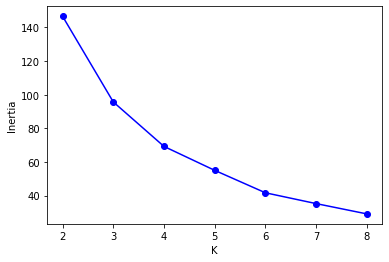

In [7]:
rand = 1
errors = []
K = range(2,9)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=rand).fit(scaled)
    errors.append(kmeans.inertia_)
    
plt.plot(K, errors, 'bo-')
plt.xticks(K)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show

This chart shows the error (`Inertia`) of the model for each value of `K`. A low error is good. Notice that as `K` increases, the error continues to drop. Intuitively, this makes sense; the more clusters you introduce, the fewer neighborhoods each cluster contains, and the closer it can match their features. If you have as many clusters as you have neighborhoods, then each neighborhood would get its own cluster and the error would be 0. But this wouldn't be a very useful application of a clustering algorithm. Our goal is to find an acceptable error value with a reasonable value for `K`.

To do this, we are looking for an "elbow" in the chart; where the line goes from going sharply downward to sharply to the right. Such an elbow represents the point where increasing `K` has a diminished effect at reducing the error. This is the sweet spot for `K`. Unfortunately, there is no elbow to be seen in this chart, so we will try a different method.

<function matplotlib.pyplot.show(close=None, block=None)>

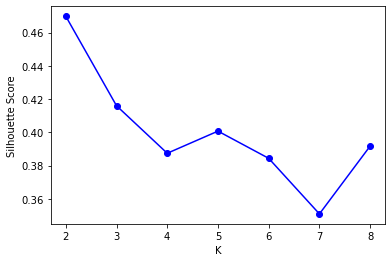

In [8]:
sil = []
K = range(2,9)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=rand).fit(scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(scaled, labels, metric = 'euclidean'))
    
plt.plot(K, sil, 'bo-')
plt.xticks(K)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show

This test is the silhouette score. Here we are looking for peaks while also picking an acceptable value for K. There are peaks K is set to 2, 5, and 8. I think 2 would be too few clusters to be meaningful. 5 and 8 have similar scores, but I think 5 is a better choice because it will make observations later in this analysis easier. So we will choose `K=5`, and group our neighborhoods into 5 clusters.


#### Results

The model assigns each neighborhood to a cluster. We will add a `CLUSTER` column to our original geographic dataframe to represent this assignment.

In [134]:
kmeans = KMeans(n_clusters=5, random_state=rand).fit(scaled)
vdf_sum['CLUSTER'] = kmeans.labels_

df_clustered = df.merge(vdf_sum[['CLUSTER']], left_on='NAME', right_on='NEIGHBORHOOD')
# df_labeled.drop('LABEL_x', axis=1, inplace=True)
df_clustered.rename({'CLUSTER_y': 'CLUSTER'}, axis=1, inplace=True)
df_clustered.sort_values(by=['CLUSTER'], inplace=True)
df_clustered.reset_index(drop=True, inplace=True)
df_clustered.drop('KM_TO_CITY_CENTER', axis=1, inplace=True)
df_clustered

,NAME,LATITUDE,LONGITUDE,CLUSTER
0,Northgate Neighborhood,47.708593,-122.323276,0
1,Admiral Neighborhood,47.581194,-122.386548,0
2,Columbia City Neighborhood,47.557847,-122.285044,0
3,Georgetown Neighborhood,47.547926,-122.316094,0
4,Magnolia Neighborhood,47.639553,-122.401007,0
5,White Center Neighborhood,47.517352,-122.354020,0
6,Central District,47.619169,-122.302550,0
7,Wallingford Neighborhood,47.661386,-122.333720,0
8,West Seattle Neighborhood,47.561105,-122.386779,0
9,Lake City Neighborhood,47.719278,-122.295228,0


Finally, let us display our clustered neighborhoods on a map like before, using colors to represent the different clusters.

In [142]:
seattle_map_clustered = folium.Map(location=seattle_coordinates, zoom_start=11)

palette = {
    0: 'darkorange',
    1: 'blue',
    2: 'green',
    3: 'darkred',
    4: 'purple',
}

for lat, lng, name, cluster in zip(df_clustered['LATITUDE'], df_clustered['LONGITUDE'], df_clustered['NAME'], df_clustered['CLUSTER']):
    popup_text = '{}\nCluster: {}'.format(name, cluster)
    _popup = folium.Popup(popup_text, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        color=palette[cluster],
        fill=True,
        fill_opacity=1.0,
        popup=_popup
    ).add_to(seattle_map_clustered)
# Uncomment to show map
# seattle_map_clustered

#### *Screenshot of map, in case Notebook is untrusted:*

![image](clustered_seattle_map.png)

#### Discussion

This approach is bound to be somewhat flawed, as there is much more to a neighborhood than the types of venues it contains. With that limitation in mind, the results were pleasantly surprising. I spent a few years living in Seattle, and would have clustered many of the neighborhoods in the same way if put to the task. 

All of the more suburban neighborhoods fell into the two largest clusters. Ballard, Fremont, Queen Anne, Green Lake, and the International District are of another cluster. These are centers of activity, full of shops, bars, and restaurants. Capitol Hill is a similar center of activity, yet the algorithm placed it with the Central Business District (the heart of downtown). This is possibly due to its sheer density and number of venues. The final cluster is the University District, home of the University of Washington. It is not surprising that this appeared in its own cluster, as it has a massive concentration of `College & University` venues.

In addition to my anecdotal evaluation, we can examine the data to get a profile for each cluster. The following bar chart shows the average number of venues in each neighborhood for each cluster.

Text(0.5, 0, 'Average Venues per Neighborhood')

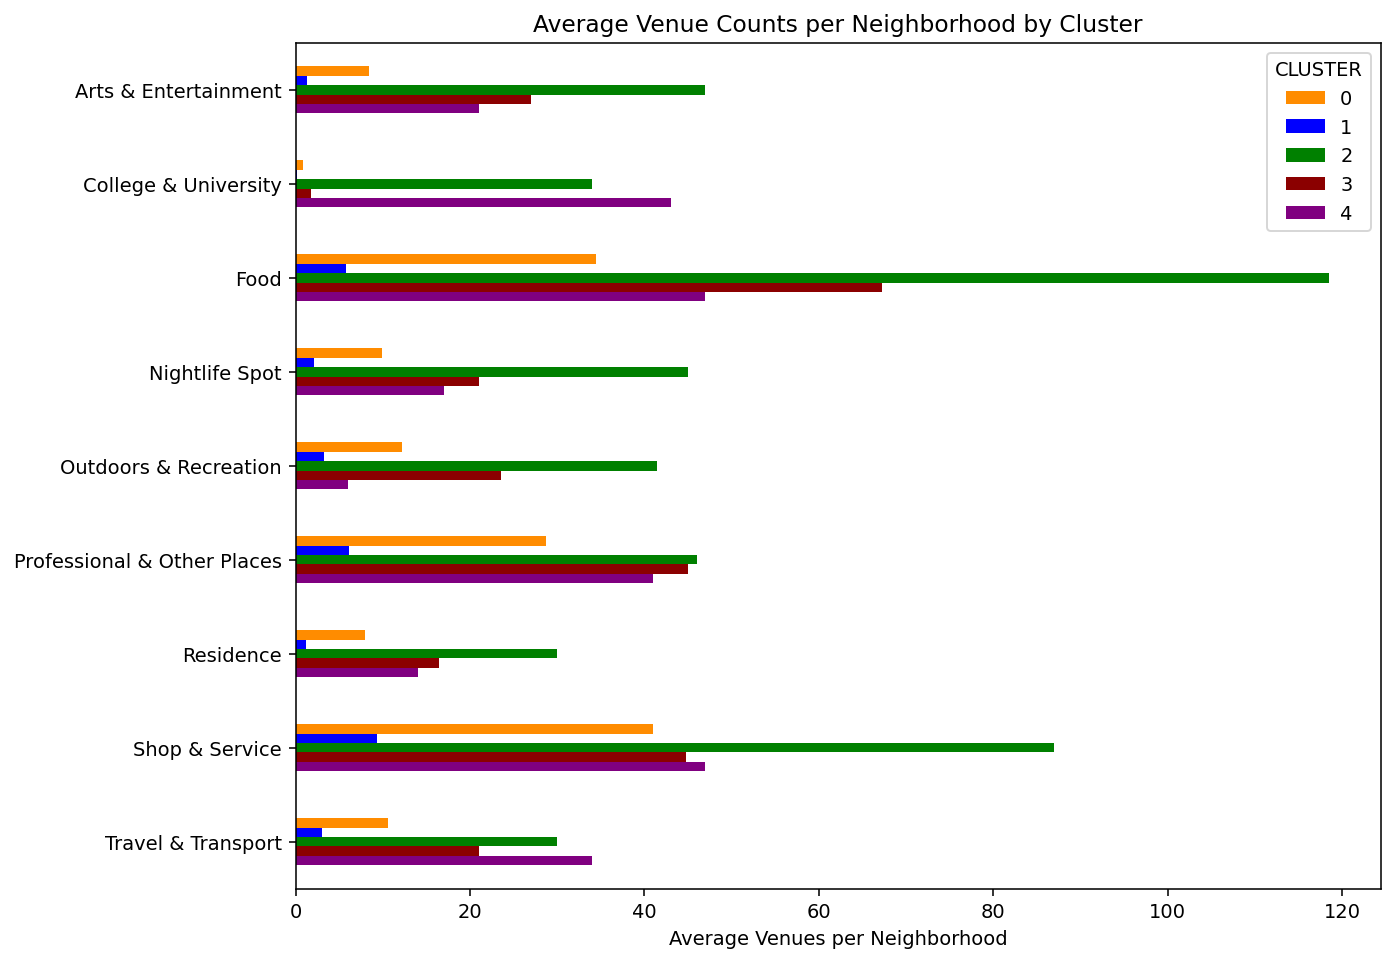

In [173]:
profiles = vdf_sum.groupby('CLUSTER').mean().transpose()

ax = profiles.plot.barh(figsize=(10,8), color=palette)

ax.invert_yaxis()
plt.title('Average Venue Counts per Neighborhood by Cluster')
plt.xlabel('Average Venues per Neighborhood')

A further piece of information which will help define our clusters is their density. We can estimate this with the average total venues per neighborhood in each cluster. You *could* get this information from the chart above, but it is easier to visualize separately.

Text(0, 0.5, 'Average Venues per Neighborhood')

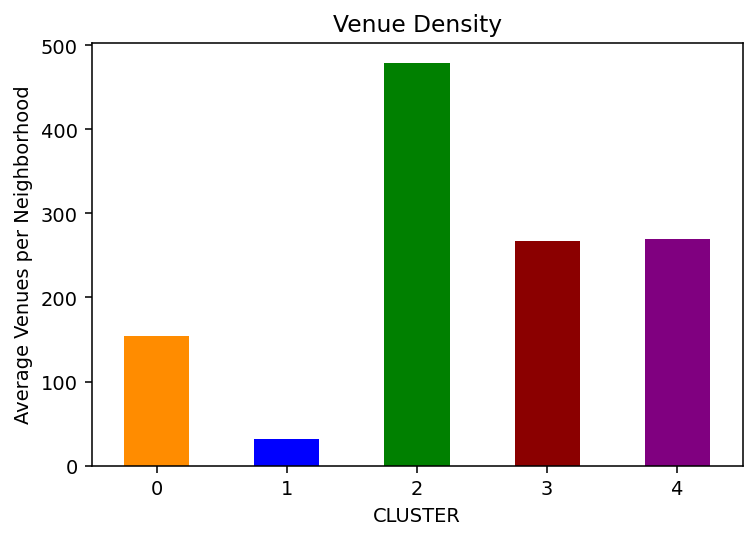

In [188]:
vdf_sum.groupby('CLUSTER').mean().transpose().sum().plot.bar(color=palette.values(),rot=0)
plt.title('Venue Density')
plt.ylabel('Average Venues per Neighborhood')

Using these charts and the map, we can make some assumptions about the clusters, and give them more human-readable names.

##### Cluster 0 - High Density Suburb
From the map, we can see that this is a semi-suburban cluster. This assertion is backed up by the fact that it has the second lowest density. Neighborhoods in this cluster have all the amenities of their more populated counterparts, but in lower quantities.

##### Cluster 1 - Low Density Suburb
This is the lowest density cluster. It has few venues of all types, and is likely not a place people often visit without living there.

##### Cluster 2 - Dense Commercial District
This is the highest density cluster. From the map, we can see that it contains 2 neighborhoods right in the heart of the city. It has the greatest number of shopping, dining, and entertainment venues. It has a proportionally lower amount of `Professional & Other Places` venues, which is a surprise considering one of the two neighborhoods is the Central Business District. It also has many `College & University` venues, signalling the presence of a colleges or universities.

##### Cluster 3 - Commercial District
This cluster has a similar venue composition to the *Dense Commercial District* cluster, but in lower quantities. 

##### Cluster 4 - University District
This cluster is an outlier, as it only contains a single neighborhood. It has similar venues to the 2 *Commercial* clusters, but with the highest proportion of `College & University` venues by far. There is also a high quantity of `Travel & Transport` venues, likely as a result of the University there.

#### Conclusion

In this report we saw how K Means clustering could be used to compare neighborhoods in Seattle based on what venues they contain. The approach has some limitations but ultimately produced a reasonable result. 